In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import scipy.fft
from scipy.special import factorial
import math
# import csv
from matplotlib import rc, rcParams

plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.autolayout'] = True

def fitlin(x, y, sig):
    '''
    Performs a least-squares linear fit

    Parameters
    ----------
    x : array
        The independent data
    y : array
        The dependent data
    sig : array
        The uncertainty in y

    Returns
    ----------
    popt : array
        Optimal values for the parameters
    perr : array
        The uncertainty on the fit parameters
    chisq : float
        The value of chi-squared
    yfit : array
        The values of the fitted line at each x
    '''

    ### See Bevington and Robinson Ch. 6 (p. 114)

    # TLDR: by minimizing the chi-squared, you get a system of equations
    ###         term3 = b * term1 + m * term5
    ###         term4 = b * term5 + m * term2
    ###     this equation can be solved by taking determinants
    ###     the inverse of the matrix (the curvature matrix of a linear ftn)
    ###         ( term1 term5 )
    ###         ( term5 term2 )
    ###     is the covariance matrix, and the diagonal terms are the fit errors
    ###     the full formulas can be found on page 114 of Bevington

    term1 = np.sum(    1 / sig**2 )
    term2 = np.sum( x**2 / sig**2 )
    term3 = np.sum(    y / sig**2 )
    term4 = np.sum(  x*y / sig**2 )
    term5 = np.sum(    x / sig**2 )

    delta = term1*term2 - term5**2

    b = ( term2*term3 - term5*term4 ) / delta
    m = ( term1*term4 - term5*term3 ) / delta
    popt = np.array([b, m])

    berr = np.sqrt( term2 / delta )
    merr = np.sqrt( term1 / delta )
    perr = np.array([berr, merr])

    yfit = b + m*x

    chisq = np.sum( ( (y - yfit) / sig )**2 )

    return popt, perr, chisq, yfit

scaling_factor = 1/2 # 50 for downsampling, divide by 20000Hz sample rate

# XX
xx = {'100': (0.385, 0.306, 0.002, 0.008), '142': (0.707, 0.987, 0.021, 0.034), '193': (0.995, 1.73, 0.007, 0.2), '292': (1.563, 2.971 , 0.041, 0.107), '392': (1.598,3.097, 0.130, 0.594), '492':(3.442, 2.83, 0.2, 0.2)}
# xx_series = pd.Series(data=xx)
yy = {'100': (0.152, .307, 0.001, 0.008), '142': (0.366, 0.818, 0.001 ,0.04), '193': (.459, 1.491, 0.033,.051), '292': (1.165, 3.115,0.039, 0.022), '393':(1.663, 4.303,.012, 0.271)}
# yy_series = pd.Series(data=yy)

# # Create scatter plot of QPD calibration gradients
# plt.figure(figsize=(10,6))

# Filter out data points above 393mA
xx_filtered = {k: v for k, v in xx.items() if float(k) <= 393}
yy_filtered = {k: v for k, v in yy.items() if float(k) <= 393}

# Extract coordinates and uncertainties from xx series
xx_x_est = np.array([v[0] for v in xx_filtered.values()]) * scaling_factor
# xx_y_est = np.array([v[1] for v in xx_filtered.values()]) * scaling_factor
xx_x_est_errs = np.array([v[2] for v in xx_filtered.values()]) * scaling_factor
# xx_y_est_errs = np.array([v[3] for v in xx_filtered.values()]) * scaling_factor

# Extract coordinates and uncertainties from yy series
# yy_x_est = np.array([v[0] for v in yy_filtered.values()]) * scaling_factor
yy_y_est = np.array([v[1] for v in yy_filtered.values()]) * scaling_factor
# yy_x_est_errs = np.array([v[2] for v in yy_filtered.values()]) * scaling_factor
yy_y_est_errs = np.array([v[3] for v in yy_filtered.values()]) * scaling_factor

qpd_x_to_pos = 1/xx_x_est
qpd_x_to_pos_err = xx_x_est_errs / xx_x_est * qpd_x_to_pos
qpd_y_to_pos = 1/yy_y_est
qpd_y_to_pos_err = yy_y_est_errs / yy_y_est * qpd_y_to_pos
print(qpd_x_to_pos, qpd_y_to_pos)

[5.19480519 2.82885431 2.01005025 1.27959053 1.25156446] [6.51465798 2.44498778 1.34138162 0.64205457 0.46479201]


In [2]:
floating_brownian_stem = 'data/Real/'
floating_brownian_suffix = 'mA_20k_10s_3u_10-29' # has _2 or just .txt
laser_powers = [100.6, 193.2, 293.2, 392.6, 493.1]
laser_power_strs = [str(power).split(".") for power in laser_powers]
dirs = ['_'.join(tup) for tup in laser_power_strs]
file_starts = ['-'.join(tup) for tup in laser_power_strs]
floating_brownian_files = [floating_brownian_stem + dirs[i] + '/' + file_starts[i] + floating_brownian_suffix for i in range(len(laser_powers))]
floating_brownian_files = [(floating_brownian_files[0] + ".txt",)] + [(file_name + ".txt", file_name + "_2.txt") for file_name in floating_brownian_files[1:]]
print(floating_brownian_files)

[('data/Real/100_6/100-6mA_20k_10s_3u_10-29.txt',), ('data/Real/193_2/193-2mA_20k_10s_3u_10-29.txt', 'data/Real/193_2/193-2mA_20k_10s_3u_10-29_2.txt'), ('data/Real/293_2/293-2mA_20k_10s_3u_10-29.txt', 'data/Real/293_2/293-2mA_20k_10s_3u_10-29_2.txt'), ('data/Real/392_6/392-6mA_20k_10s_3u_10-29.txt', 'data/Real/392_6/392-6mA_20k_10s_3u_10-29_2.txt'), ('data/Real/493_1/493-1mA_20k_10s_3u_10-29.txt', 'data/Real/493_1/493-1mA_20k_10s_3u_10-29_2.txt')]


In [3]:
data = []
for power_tuple in floating_brownian_files:
    power_data = []
    for trial_file in power_tuple:
        with open(trial_file, mode ='r') as file:
            lines = file.readlines()
            power_data += [[[float(i) for i in line.split("\t")] for line in lines]]

    data += [np.array(power_data)]

for i, power_tuple in enumerate(data):
    trial_fits = []
    for trial_data in power_tuple:
        # plt.plot(trial_data[:,0], trial_data[:,1], lw=0.1)
        # plt.show()
        trial_data[:,0]
        trial_data[:,2]
        trial_data[:,1]
        trial_data[:,3]

(9999,) (9999,) [  50 1000] [ 40 900] [  80 1100]
[0.06043888] [[1.90671848e-05]]
[ 2.20715438 -1.31095296] [[ 0.00567737 -0.00092601]
 [-0.00092601  0.00015309]]


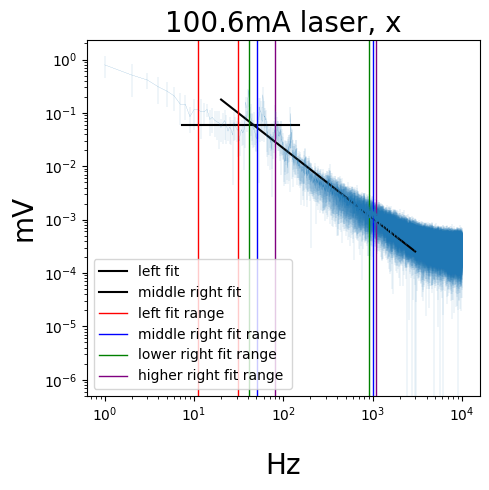

(9999,) (9999,) [  81 1010] [ 51 910] [ 111 1210]
[0.09532592] [[3.77752378e-05]]
[ 2.73701155 -1.3037177 ] [[ 0.00703555 -0.00113326]
 [-0.00113326  0.00018445]]


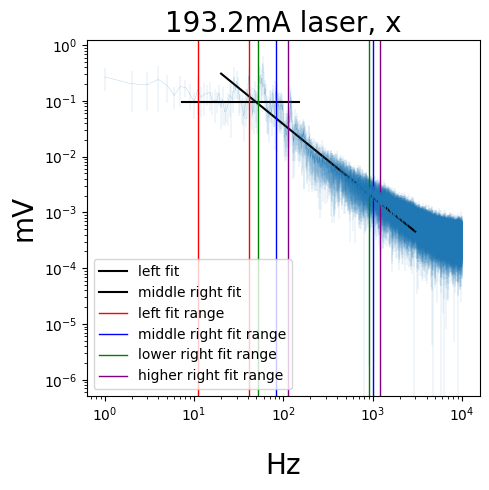

(9999,) (9999,) [  81 1010] [ 51 910] [ 111 1210]
[0.08662444] [[5.00533486e-05]]
[ 2.94840584 -1.34187049] [[ 0.00830982 -0.00134028]
 [-0.00134028  0.00021852]]


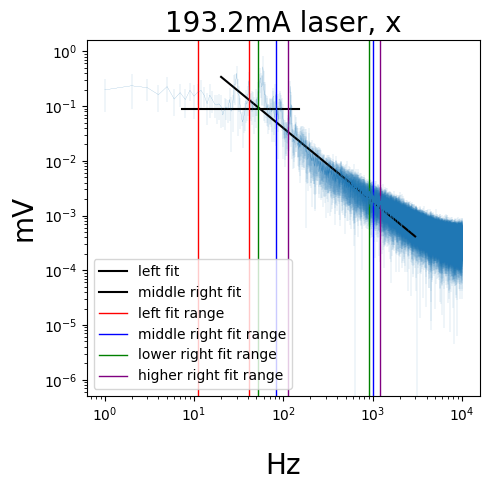

(9999,) (9999,) [  82 1020] [ 52 920] [ 112 1320]
[0.19887918] [[7.56526515e-05]]
[ 3.78199302 -1.32117622] [[ 0.00780517 -0.00124594]
 [-0.00124594  0.00020067]]


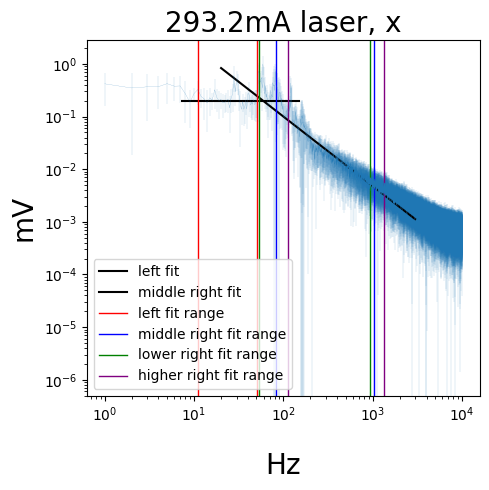

(9999,) (9999,) [  82 1020] [ 52 920] [ 112 1320]
[0.17254758] [[8.30540009e-05]]
[ 3.34885831 -1.28637143] [[ 0.00612823 -0.00098514]
 [-0.00098514  0.00015995]]


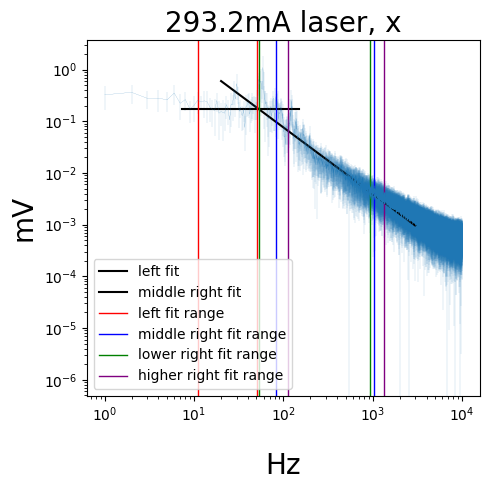

(9999,) (9999,) [  83 1030] [ 53 930] [ 113 1430]
[0.27536988] [[0.00019917]]
[ 4.36576478 -1.35623854] [[ 0.0107246  -0.00172814]
 [-0.00172814  0.00028157]]


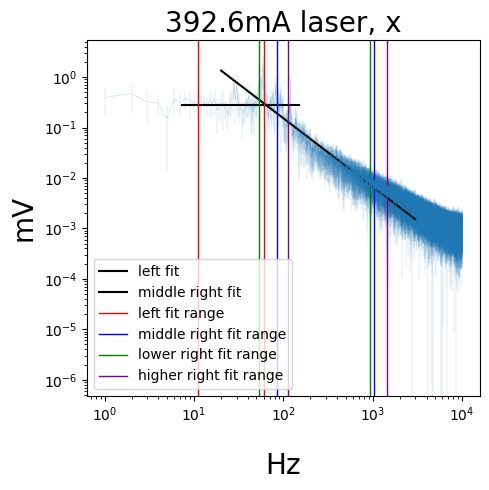

(9999,) (9999,) [  83 1030] [ 53 930] [ 113 1430]
[0.28171059] [[0.00025845]]
[ 3.80730807 -1.26913093] [[ 0.00647428 -0.00103892]
 [-0.00103892  0.00016839]]


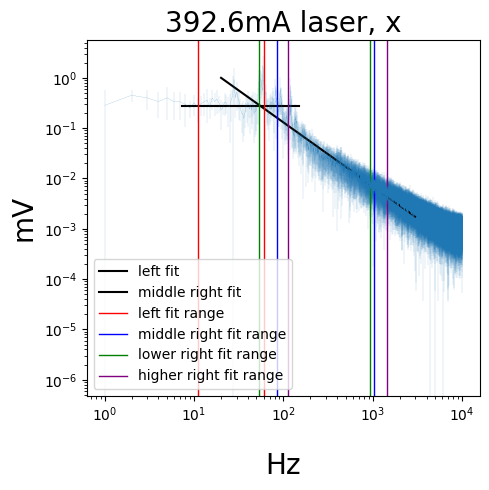

(9999,) (9999,) [  84 1040] [ 54 940] [ 114 1540]
[0.22468715] [[0.00017238]]
[ 4.06430298 -1.34118616] [[ 0.00858989 -0.00137466]
 [-0.00137466  0.00022216]]


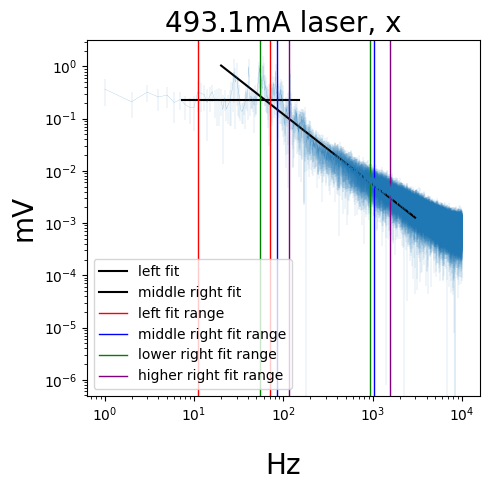

(9999,) (9999,) [  84 1040] [ 54 940] [ 114 1540]
[0.25984227] [[0.00017803]]
[ 4.06425558 -1.30682189] [[ 0.00685828 -0.00109915]
 [-0.00109915  0.00017799]]


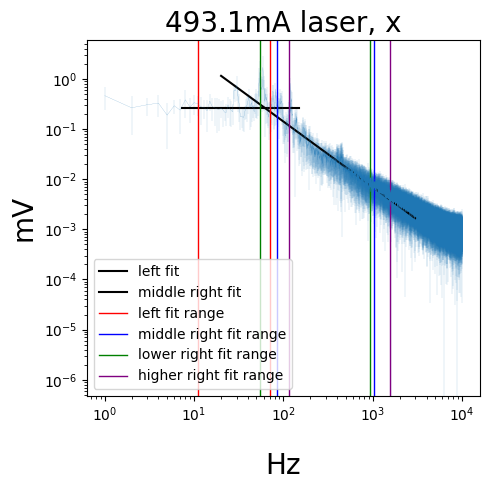

(9999,) (9999,) [  50 1000] [ 40 900] [  80 1100]
[0.12285614] [[4.88755832e-05]]
[ 2.00555413 -1.19351038] [[ 0.00444001 -0.0007254 ]
 [-0.0007254   0.00012022]]


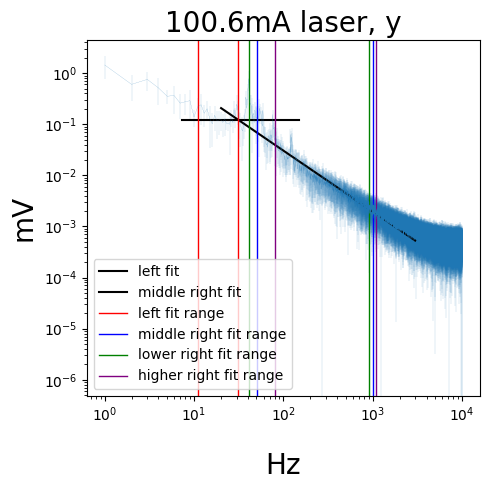

(9999,) (9999,) [  81 1010] [ 51 910] [ 111 1210]
[0.08399209] [[2.54355428e-05]]
[ 1.58216951 -1.15421257] [[ 0.00394014 -0.00063539]
 [-0.00063539  0.00010355]]


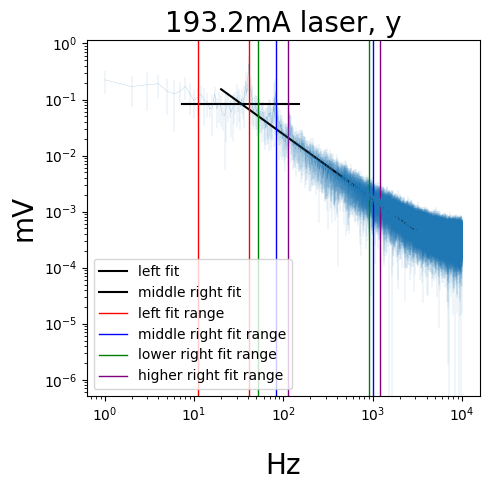

(9999,) (9999,) [  81 1010] [ 51 910] [ 111 1210]
[0.0931187] [[3.19812752e-05]]
[ 1.55031847 -1.14486722] [[ 0.00472316 -0.00076045]
 [-0.00076045  0.00012371]]


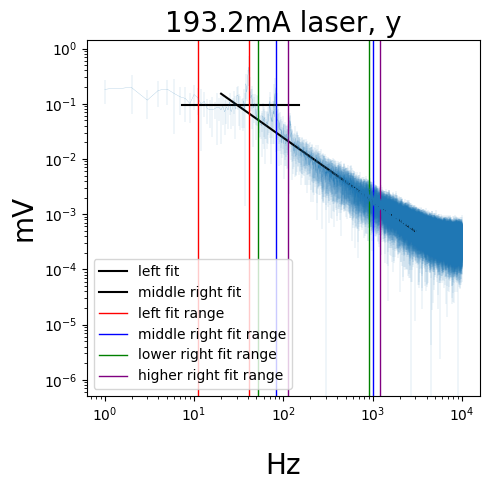

(9999,) (9999,) [  82 1020] [ 52 920] [ 112 1320]
[0.12281955] [[5.74372063e-05]]
[ 2.45796715 -1.20969329] [[ 0.0062519  -0.00099042]
 [-0.00099042  0.00015801]]


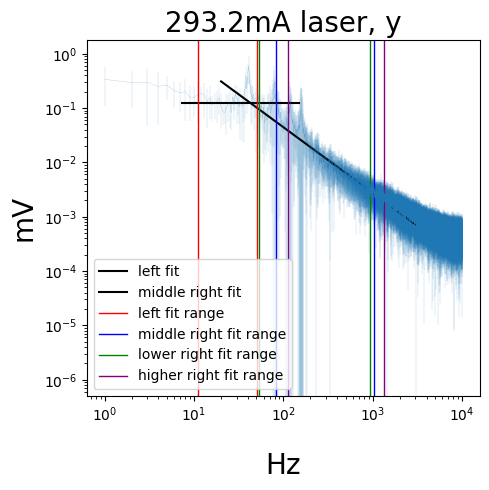

(9999,) (9999,) [  82 1020] [ 52 920] [ 112 1320]
[0.12274229] [[5.68157022e-05]]
[ 1.97089463 -1.13845065] [[ 3.48144811e-03 -5.60729662e-04]
 [-5.60729662e-04  9.12932145e-05]]


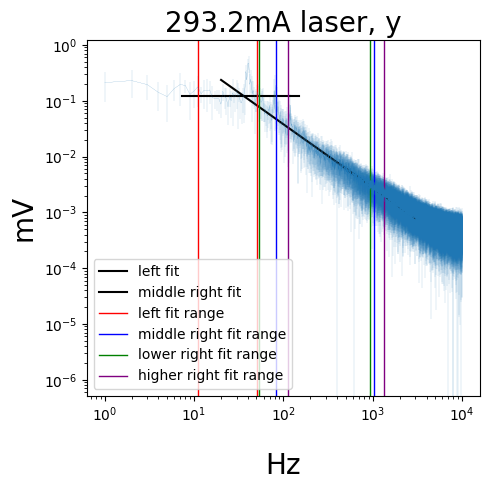

(9999,) (9999,) [  83 1030] [ 53 930] [ 113 1430]
[0.14469039] [[6.1291292e-05]]
[ 2.15472118 -1.11859735] [[ 3.79188634e-03 -6.06860098e-04]
 [-6.06860098e-04  9.80931910e-05]]


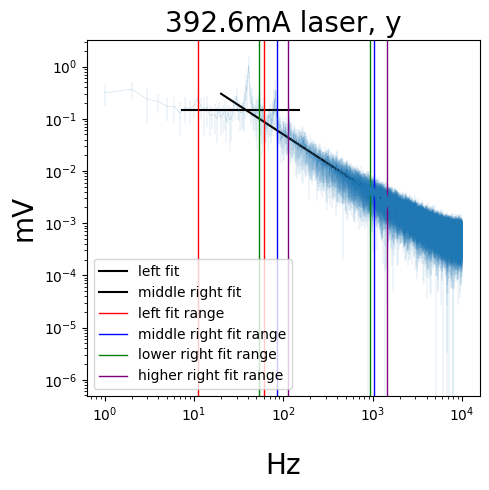

(9999,) (9999,) [  83 1030] [ 53 930] [ 113 1430]
[0.15486712] [[8.31458974e-05]]
[ 2.307755   -1.13355102] [[ 3.19900302e-03 -5.11915994e-04]
 [-5.11915994e-04  8.27159509e-05]]


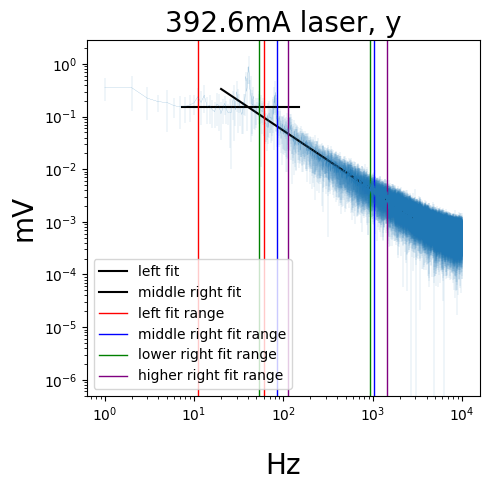

(9999,) (9999,) [  84 1040] [ 54 940] [ 114 1540]
[0.15740627] [[5.94990043e-05]]
[ 2.51825235 -1.12062385] [[ 0.00465577 -0.00074441]
 [-0.00074441  0.00012016]]


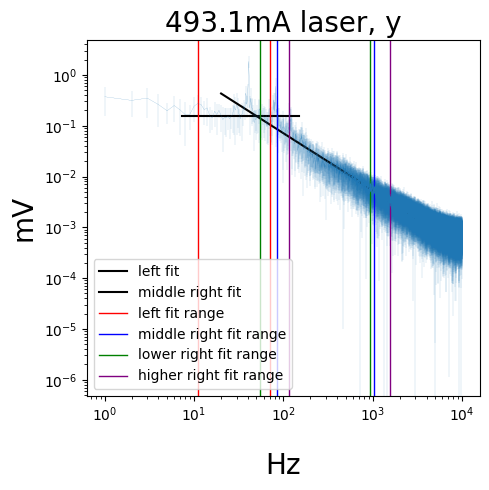

(9999,) (9999,) [  84 1040] [ 54 940] [ 114 1540]
[0.13587564] [[5.14599543e-05]]
[ 2.64361435 -1.15807237] [[ 3.27108014e-03 -5.26785546e-04]
 [-5.26785546e-04  8.58145526e-05]]


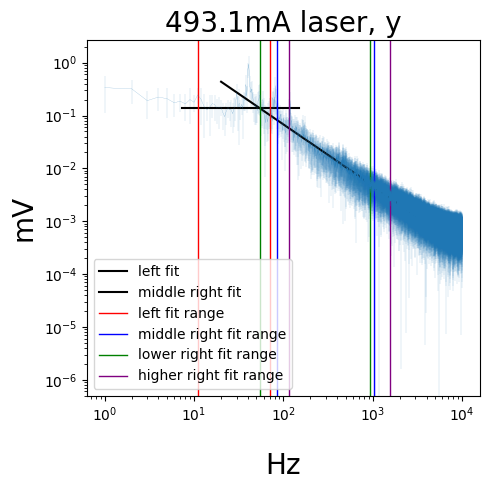

In [4]:
fits = []
for axis in range(2):
    fitsforaxis = []
    for i, power_tuple in enumerate(data):
        trial_fits = []
        for trial_data in power_tuple:
            # plt.plot(trial_data[:,0], trial_data[:,1], lw=0.1)
            # plt.show()
            sampling_rate = 20000
            bin_length = len(trial_data) // 10
            binned_data = np.reshape(trial_data[:,axis], (-1, bin_length))
            avgs = np.sum(binned_data, axis=-1, keepdims=True) / bin_length
            binned_data -= avgs

            amps = abs(scipy.fft.fft(binned_data) / (np.sqrt(bin_length))) # because we want "ortho" normalization ? # np.sqrt(len(dists)) *
            amps = amps[:,1:bin_length//2]
            # amps = np.sqrt(pwsp) # for OUR psd take the sqrt of the power spectrum? because that's what it says?
            # freqs = np.array(range(len(amps))) * sampling_rate
            freqs = scipy.fft.fftfreq(bin_length, d=1/2e4, device=None)
            freqs = freqs[1:len(freqs)//2]
            # print(amps.shape)
            # for amp_data in amps:
            #     print(np.argmin(amp_data))
            #     plt.loglog(freqs, (amp_data), lw=0.1, color="grey", label="fourier spectrum")
            #     plt.show()
            means = np.sum(amps, axis=0, keepdims=True) / len(amps)
            variances = np.sum((amps - means) ** 2, axis=0) / (len(amps) - 1)
            stds = np.sqrt(variances)
            means = means[0]
            plt.errorbar(freqs, means, yerr=stds, lw=0.1)
            plt.yscale('log')
            plt.xscale('log')

            def constant_fit(x, c):
                return c
            def neg1_slope_fit(x, c, m):
                return m*np.array(x) + c
            constrange = np.array([10, 3*10 + i*10])
            neg1range = np.array([80 + i*1 if i> 0 else 50, 1*10**3 + i*10])
            neg1rangeless = np.array([neg1range[0]-30 if i>0 else neg1range[0]-10, neg1range[1]-100])
            neg1rangemore = np.array([neg1range[0]+30, neg1range[1]+100*(i+1)])
            print(stds.shape, means.shape, neg1range, neg1rangeless, neg1rangemore)
            constopt, constcov = opt.curve_fit(constant_fit, freqs[constrange[0]:constrange[1]], means[constrange[0]:constrange[1]], p0=(1), sigma=stds[constrange[0]:constrange[1]])
            neg1opt, neg1cov = opt.curve_fit(neg1_slope_fit, np.log(freqs[neg1range[0]:neg1range[1]]), np.log(means[neg1range[0]:neg1range[1]]), p0=(1, -1), sigma=(stds / means)[neg1range[0]:neg1range[1]])
            neg1optless, neg1covless = opt.curve_fit(neg1_slope_fit, np.log(freqs[neg1rangeless[0]:neg1rangeless[1]]), np.log(means[neg1rangeless[0]:neg1rangeless[1]]), p0=(1, -1), sigma=(stds / means)[neg1rangeless[0]:neg1rangeless[1]])
            neg1optmore, neg1covmore = opt.curve_fit(neg1_slope_fit, np.log(freqs[neg1rangemore[0]:neg1rangemore[1]]), np.log(means[neg1rangemore[0]:neg1rangemore[1]]), p0=(1, -1), sigma=(stds / means)[neg1rangemore[0]:neg1rangemore[1]])
            print(constopt, constcov)
            print(neg1opt, neg1cov)
            plottingconst = np.linspace(2, 5, 100)
            plottingneg1 = np.linspace(3, 8, 100) 
            plt.loglog(np.e ** plottingconst, np.array([constopt[0]] * 100), color="black", label="left fit")
            plt.loglog(np.e ** plottingneg1, np.e ** (neg1opt[1] * plottingneg1 + np.array([neg1opt[0]] * 100)), color="black", label="middle right fit")
            plt.axline((freqs[constrange[0]], 1e-3), (freqs[constrange[0]], 1e-6), linewidth=1, color='r', label="left fit range")
            plt.axline((freqs[constrange[1]], 1e-3), (freqs[constrange[1]], 1e-6), linewidth=1, color='r')
            plt.axline((freqs[neg1range[0]], 1e-3), (freqs[neg1range[0]], 1e-6), linewidth=1, color='b', label="middle right fit range")
            plt.axline((freqs[neg1range[1]], 1e-3), (freqs[neg1range[1]], 1e-6), linewidth=1, color='b')
            plt.axline((freqs[neg1rangeless[0]], 1e-3), (freqs[neg1rangeless[0]], 1e-6), linewidth=1, color='g', label="lower right fit range")
            plt.axline((freqs[neg1rangeless[1]], 1e-3), (freqs[neg1rangeless[1]], 1e-6), linewidth=1, color='g')
            plt.axline((freqs[neg1rangemore[0]], 1e-3), (freqs[neg1rangemore[0]], 1e-6), linewidth=1, color='purple', label="higher right fit range")
            plt.axline((freqs[neg1rangemore[1]], 1e-3), (freqs[neg1rangemore[1]], 1e-6), linewidth=1, color='purple')

            plt.xlabel(r'Hz', fontsize=20, labelpad=20)
            plt.ylabel(r'mV', fontsize=20)
            # plt.legend(loc="upper right" if ind != 4 else "lower right",fontsize=15,ncol = 1)
            # add title if necessary
            plt.title(f'{laser_powers[i]}mA laser, {"x" if axis==0 else "y"}', fontsize=20)
            plt.legend(loc="lower left",fontsize=10,ncol = 1)
            plt.show()

            trial_fits += [{'c':(constopt, constcov), 'bm':(neg1opt, neg1cov), 'bmless':(neg1optless, neg1covless), 'bmmore':(neg1optmore, neg1covmore)}]
        fitsforaxis += [trial_fits]
    fits += [fitsforaxis]

In [5]:
# print(fits)
f0s = []

beta_23c = 0.9358 * 1e-3 * 3 * np.pi * 3.21e-6
beta_err = 0.003 * 1e-3 * 3 * np.pi * 3.21e-6

for fits_axis in fits:
    axis_f0 = []
    for power in fits_axis:
        power_f0 = []
        for trial in power:
            # we want f0 * m + b = c => f0 = (c-b)/m
            subtraction = (np.log(trial['c'][0]) - trial['bm'][0][0])
            division = trial['bm'][0][1]
            f0beforee = subtraction / division # this is alpha/(2*pi*beta)
            f0 = np.e ** f0beforee
            f0less = np.e ** ((np.log(trial['c'][0]) - trial['bmless'][0][0]) / trial['bmless'][0][1])
            f0more = np.e ** ((np.log(trial['c'][0]) - trial['bmmore'][0][0]) / trial['bmmore'][0][1])
            # need: beta!
            # err is (sq of err before exponentiation) * (sq of derivative of exponent which is just... the exponent)
            f0err = np.sqrt((trial['c'][1]/trial['c'][0] ** 2 + trial['bm'][1][0,0] ** 2) / (subtraction ** 2) + trial['bm'][1][1,1] ** 2 / (division ** 2)) * f0
            print(f0, f0err, f0-f0less, f0more-f0)
            power_f0 += [{'f0': f0, 'lerr': f0-f0more, 'herr': f0less-f0}]

        axis_f0 += [power_f0]
    f0s += [axis_f0]

[45.79373015] [[0.66200633]] [-1.87310558] [-5.94418565]
[49.51497095] [[0.63128399]] [-10.37847846] [-10.06327072]
[55.71189114] [[0.847867]] [-8.427378] [-10.74808164]
[59.44400474] [[0.48939177]] [-12.38717436] [-11.09168218]
[52.94525179] [[0.55138823]] [-10.36799494] [-9.50974359]
[64.71020859] [[0.59927217]] [-9.14302986] [-12.56374063]
[54.49754804] [[0.61688295]] [-10.10597653] [-10.18418027]
[63.02980329] [[0.66993583]] [-10.38831572] [-14.65285044]
[62.88425599] [[0.60202195]] [-8.91090081] [-12.10407702]
[31.09875185] [[0.43270756]] [-3.97987027] [-7.26053901]
[33.67845679] [[0.49926895]] [-3.15396924] [-3.78718968]
[30.80402377] [[0.47817561]] [-4.49957895] [-4.40325847]
[43.18194314] [[0.58800366]] [-4.0646522] [-6.25408352]
[35.65081015] [[0.53897822]] [-3.86446228] [-4.40435728]
[38.64702642] [[0.51280349]] [-6.27158018] [-4.21828016]
[39.69801773] [[0.56096197]] [-4.02432368] [-4.37187654]
[49.25913641] [[0.55525145]] [-8.00282144] [-4.88680427]
[54.9453034] [[0.6264429

/var/folders/62/x3ck94bx3vd6dfbs23ltb9dw0000gn/T/ipykernel_35223/111755197.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trial_alphas += [float(alpha)]
/var/folders/62/x3ck94bx3vd6dfbs23ltb9dw0000gn/T/ipykernel_35223/111755197.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trial_lerrs += [float(alphalerr)]
/var/folders/62/x3ck94bx3vd6dfbs23ltb9dw0000gn/T/ipykernel_35223/111755197.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trial_herrs += [floa

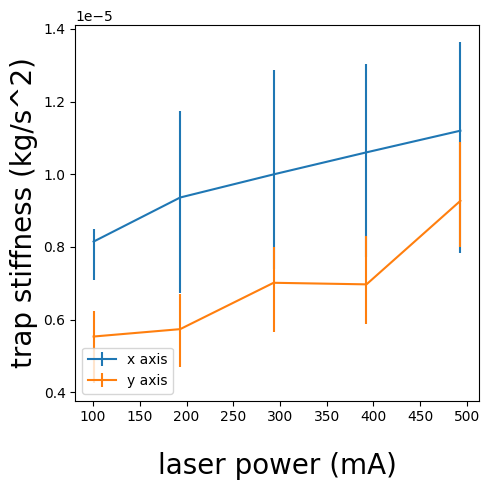

In [6]:
alphas = []
for axis, powers_axis in enumerate(f0s):
    points = []
    for i, power in enumerate(powers_axis):
        trial_alphas = []
        trial_lerrs = []
        trial_herrs = []
        for trial in power:
            alpha = trial['f0'] * 2 * np.pi * beta_23c
            alphalerr = ((trial['lerr'] / trial['f0']) ** 2 + (beta_err / beta_23c) ** 2) ** 0.5 * alpha
            alphaherr = ((trial['herr'] / trial['f0']) ** 2 + (beta_err / beta_23c) ** 2) ** 0.5 * alpha
            trial_alphas += [float(alpha)]
            trial_lerrs += [float(alphalerr)]
            trial_herrs += [float(alphaherr)]
            # plt.errorbar(laser_powers[i], alpha, yerr=(alphalerr, alphaherr))
        mean_alpha = sum(trial_alphas) / len(trial_alphas)
        trial_lerrs = np.array(trial_lerrs)
        trial_herrs = np.array(trial_herrs)
        lerr_alpha = np.sqrt(np.sum(trial_lerrs ** 2))
        herr_alpha = np.sqrt(np.sum(trial_herrs ** 2))
        points += [[laser_powers[i], float(mean_alpha), float(lerr_alpha), float(herr_alpha)]]
    points = np.array(points)
    alphas += [points[:,1]]
    plt.errorbar(points[:,0], points[:,1], yerr=(points[:,2], points[:,3]), label=f'{"x" if axis==0 else "y"} axis')

plt.xlabel(r'laser power (mA)', fontsize=20, labelpad=20)
plt.ylabel(r'trap stiffness (kg/s^2)', fontsize=20)
# plt.legend(loc="upper right" if ind != 4 else "lower right",fontsize=15,ncol = 1)
# add title if necessary
# plt.title(f'{laser_powers[i]}mA laser, {"x" if axis==0 else "y"}', fontsize=20)
plt.legend(loc="lower left",fontsize=10,ncol = 1)

In [7]:
print(xx_x_est, yy_y_est)

T = 296.35
Terr = 0.2

k_Bs = []

print(laser_powers)
for power_axis in fits:
    for power in range(len(power_axis[:-1])):
        for trial in power_axis[power]:
            k_B = (trial['c'][0] * qpd_x_to_pos[i] * 10**(-6)) ** 2 * np.pi ** 2 * beta_23c / T
            print(trial['c'][0], qpd_x_to_pos[i], k_B)  # *= qpd_x_to_pos[i] * 10**(-6)
            k_Bs += [k_B]
        # print()

k_Bs = np.array(k_Bs)
mean = np.sum(k_Bs) / len(k_Bs)
std = np.sqrt(np.sum((k_Bs - mean) ** 2) / len(k_Bs))
print(mean, std)

[0.1925 0.3535 0.4975 0.7815 0.799 ] [0.1535 0.409  0.7455 1.5575 2.1515]
[100.6, 193.2, 293.2, 392.6, 493.1]
[0.06043888] 1.2515644555694618 [5.39502248e-24]
[0.09532592] 1.2515644555694618 [1.34209258e-23]
[0.08662444] 1.2515644555694618 [1.10825905e-23]
[0.19887918] 1.2515644555694618 [5.84169793e-23]
[0.17254758] 1.2515644555694618 [4.39721984e-23]
[0.27536988] 1.2515644555694618 [1.11993635e-22]
[0.28171059] 1.2515644555694618 [1.17210575e-22]
[0.12285614] 1.2515644555694618 [2.22922659e-23]
[0.08399209] 1.2515644555694618 [1.04192693e-23]
[0.0931187] 1.2515644555694618 [1.28066112e-23]
[0.12281955] 1.2515644555694618 [2.22789874e-23]
[0.12274229] 1.2515644555694618 [2.2250969e-23]
[0.14469039] 1.2515644555694618 [3.09200225e-23]
[0.15486712] 1.2515644555694618 [3.54224763e-23]
3.699160915321611e-23 3.4613692865543767e-23


[0.00344107 0.00311257 0.00344107 ... 0.01690206 0.01690206 0.01624496]
[1.78756894e-08 1.61691959e-08 1.78756894e-08 ... 8.78029144e-08
 8.78029144e-08 8.43894079e-08] 200000 2.737827753766234e-07
[3.19540272e-16 2.61442896e-16 3.19540272e-16 ... 7.70935178e-15
 7.70935178e-15 7.12157217e-15] 8.992205677882005e-14
6.180847288324679e-15
1.6989796288916677e-22


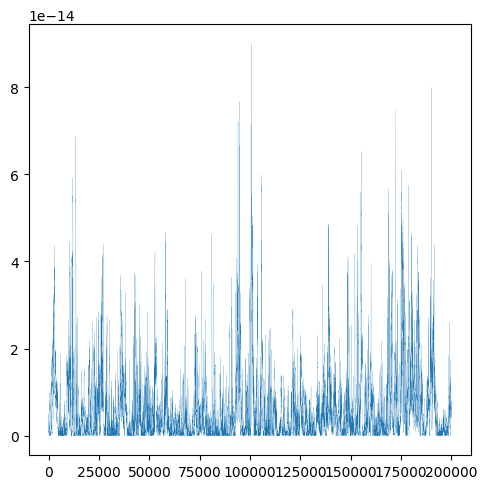

[-0.01713052 -0.01713052 -0.01647352 ... -0.00110494 -0.00110494
 -0.00110494]
[-4.84597472e-08 -4.84597472e-08 -4.66011900e-08 ... -3.12572730e-09
 -3.12572730e-09 -3.12572730e-09] 200000 1.8998001357850059e-07
[2.34834710e-15 2.34834710e-15 2.17167091e-15 ... 9.77017114e-18
 9.77017114e-18 9.77017114e-18] 4.108111611035967e-14
2.1052671755318967e-15
6.648719035073492e-23


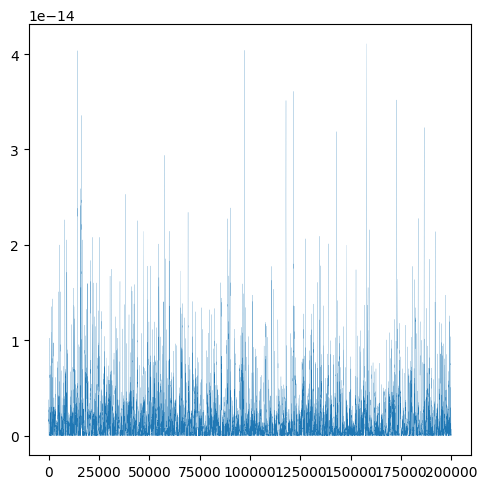

[ 0.00639482  0.00672282  0.00606582 ... -0.00587065 -0.00554265
 -0.00488565]
[ 1.80900260e-08  1.90178902e-08  1.71593330e-08 ... -1.66072086e-08
 -1.56793444e-08 -1.38207871e-08] 200000 1.7028976912305515e-07
[3.27249042e-16 3.61680149e-16 2.94442708e-16 ... 2.75799378e-16
 2.45841841e-16 1.91014157e-16] 7.686738535029299e-14
2.543810081880481e-15
8.033696962352304e-23


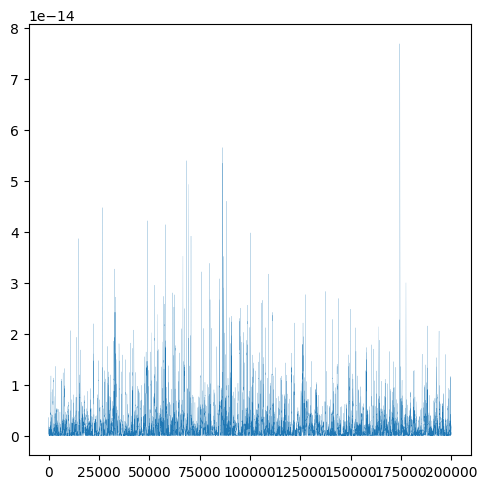

[-0.00583121 -0.00583121 -0.00681621 ... -0.00889003 -0.01119003
 -0.01020403]
[-1.17210173e-08 -1.17210173e-08 -1.37009168e-08 ... -1.78694139e-08
 -2.24925294e-08 -2.05106199e-08] 200000 2.6633723211979895e-07
[1.37382246e-16 1.37382246e-16 1.87715121e-16 ... 3.19315952e-16
 5.05913881e-16 4.20685529e-16] 9.102165880151748e-13
6.360304326766548e-15
2.145392886477982e-22


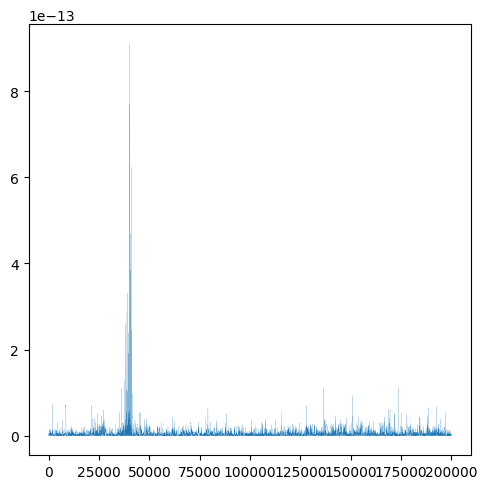

[-0.0566593  -0.0612593  -0.0599453  ... -0.00067094 -0.00034294
  0.00162806]
[-1.13888041e-07 -1.23134272e-07 -1.20493066e-07 ... -1.34861960e-09
 -6.89323116e-10  3.27248593e-09] 200000 2.1458127266331647e-07
[1.29704860e-14 1.51620491e-14 1.45185791e-14 ... 1.81877482e-18
 4.75166358e-19 1.07091642e-17] 7.953966449674238e-14
4.139862146059055e-15
1.3964160113813006e-22


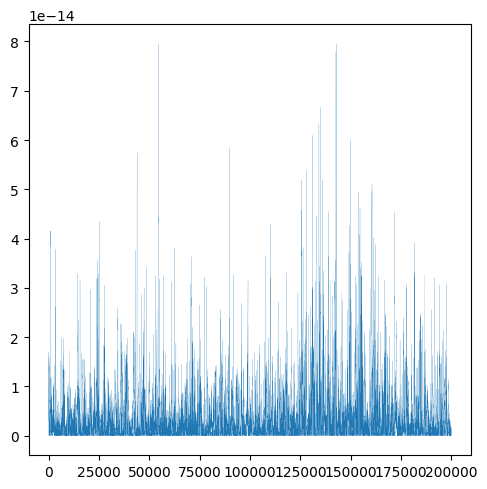

[0.03079775 0.03079775 0.02981175 ... 0.08612257 0.08776557 0.08809457]
[3.94085104e-08 3.94085104e-08 3.81468342e-08 ... 1.10201622e-07
 1.12303989e-07 1.12724974e-07] 200000 1.9532349213051816e-07
[1.55303069e-15 1.55303069e-15 1.45518096e-15 ... 1.21443975e-14
 1.26121860e-14 1.27069198e-14] 8.890641270048743e-14
4.135875976667029e-15
1.4797084840550933e-22


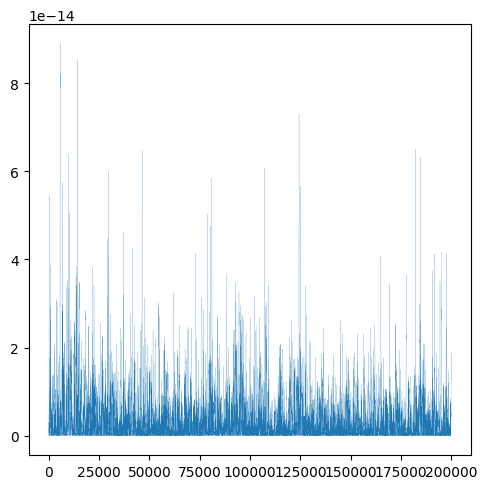

[0.07519047 0.07650447 0.07946147 ... 0.01483924 0.01385424 0.01319724]
[9.62130125e-08 9.78943944e-08 1.01678144e-07 ... 1.89881561e-08
 1.77277594e-08 1.68870685e-08] 200000 2.1980994145873333e-07
[9.25694377e-15 9.58331246e-15 1.03384449e-14 ... 3.60550072e-16
 3.14273455e-16 2.85173081e-16] 1.5126329587137484e-13
4.437665420099613e-15
1.5876808706461746e-22


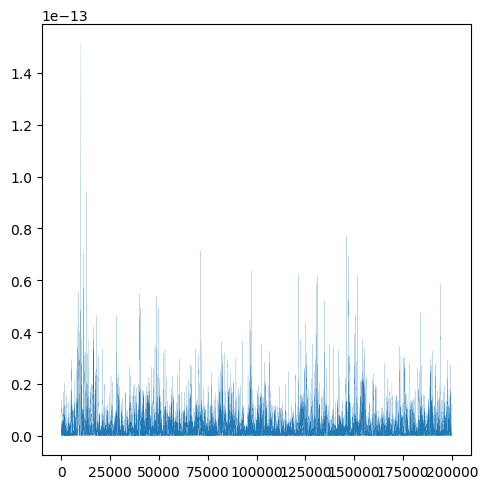

[0.01032952 0.01000152 0.01032952 ... 0.01174093 0.01042693 0.01042693]
[5.36598262e-08 5.19559301e-08 5.36598262e-08 ... 6.09918218e-08
 5.41658478e-08 5.41658478e-08] 200000 5.161793067532465e-07
[2.87937695e-15 2.69941868e-15 2.87937695e-15 ... 3.72000233e-15
 2.93393907e-15 2.93393907e-15] 2.6644107672026227e-13
1.9608797351282106e-14
3.66039585385416e-22


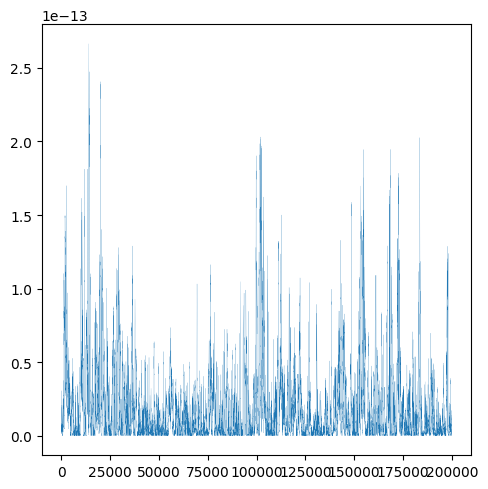

[-0.00747859 -0.00747859 -0.00714959 ... -0.01199069 -0.01199069
 -0.01166269]
[-2.11558525e-08 -2.11558525e-08 -2.02251594e-08 ... -3.39199040e-08
 -3.39199040e-08 -3.29920397e-08] 200000 2.1648850975954738e-07
[4.47570094e-16 4.47570094e-16 4.09057073e-16 ... 1.15055988e-15
 1.15055988e-15 1.08847469e-15] 4.686727485790964e-14
1.055279994453535e-15
2.0422719980696175e-23


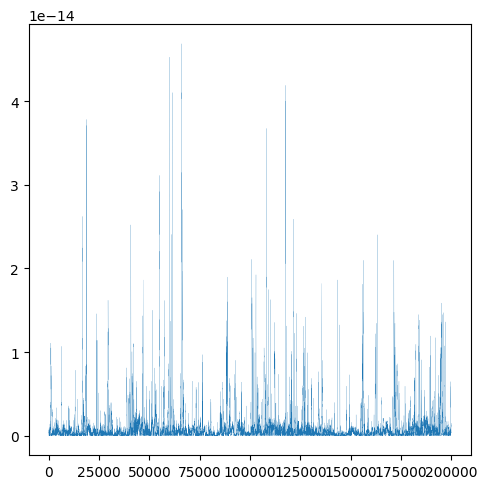

[-0.00423953 -0.00391053 -0.00423953 ... -0.00477824 -0.00576424
 -0.00477824]
[-1.19930201e-08 -1.10623270e-08 -1.19930201e-08 ... -1.35169451e-08
 -1.63061955e-08 -1.35169451e-08] 200000 3.1009257666195193e-07
[1.43832531e-16 1.22375079e-16 1.43832531e-16 ... 1.82707805e-16
 2.65892011e-16 1.82707805e-16] 9.61574061008485e-14
1.2710329013321994e-15
2.4598162730831808e-23


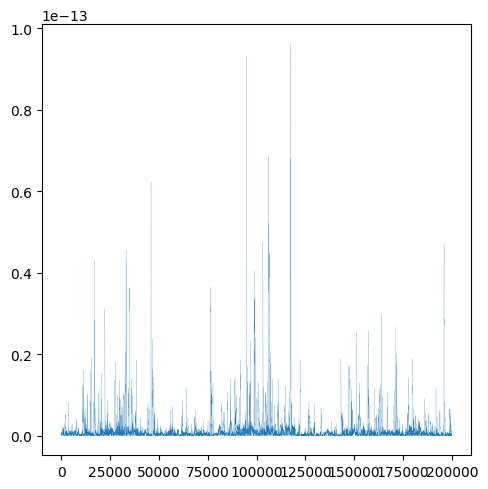

[0.00209768 0.00111168 0.00209768 ... 0.02133486 0.02396386 0.02593486]
[4.21644854e-09 2.23453899e-09 4.21644854e-09 ... 4.28841339e-08
 4.81685560e-08 5.21303650e-08] 200000 8.309500294472359e-07
[1.77784383e-17 4.99316452e-18 1.77784383e-17 ... 1.83904894e-15
 2.32020979e-15 2.71757496e-15] 6.904779514383622e-13
1.8374737621618938e-15
4.347423844383632e-23


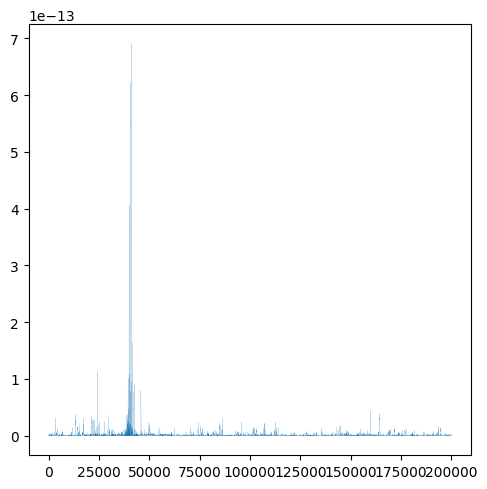

[-0.01257066 -0.01191366 -0.01191366 ... -0.00232902 -0.00265802
 -0.00232902]
[-2.52676639e-08 -2.39470609e-08 -2.39470609e-08 ... -4.68145296e-09
 -5.34275950e-09 -4.68145296e-09] 200000 2.2854367175879393e-07
[6.38454840e-16 5.73461726e-16 5.73461726e-16 ... 2.19160019e-17
 2.85450790e-17 2.19160019e-17] 5.2232209900991357e-14
9.718011577380927e-16
2.299260872263801e-23


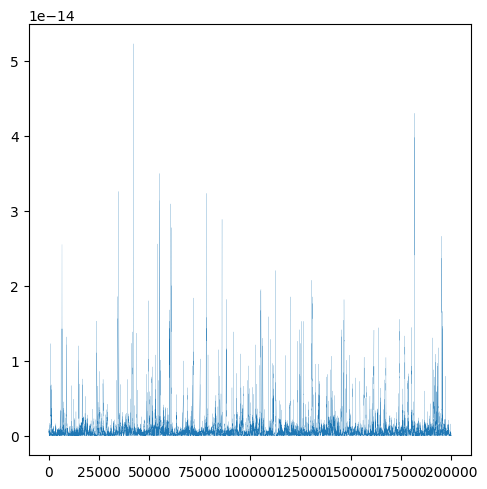

[-0.01835615 -0.01704215 -0.01704215 ...  0.01712893  0.01647193
  0.01877193]
[-2.34883550e-08 -2.18069730e-08 -2.18069730e-08 ...  2.19180214e-08
  2.10773305e-08  2.40203887e-08] 200000 1.9811571906589894e-07
[5.51702819e-16 4.75544071e-16 4.75544071e-16 ... 4.80399664e-16
 4.44253859e-16 5.76979072e-16] 3.924983814099819e-14
8.81063352992501e-16
2.0716806469089874e-23


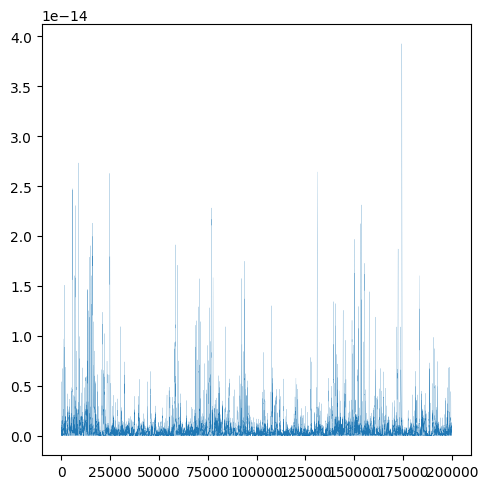

[ 0.02390649  0.02752049  0.02850549 ... -0.02256008 -0.02190308
 -0.02256008]
[ 3.05905233e-08  3.52149635e-08  3.64753601e-08 ... -2.88676662e-08
 -2.80269752e-08 -2.88676662e-08] 200000 2.107599729366603e-07
[9.35780115e-16 1.24009365e-15 1.33045190e-15 ... 8.33342153e-16
 7.85511341e-16 8.33342153e-16] 4.441976619226177e-14
9.023577601245646e-16
2.1217510657875628e-23


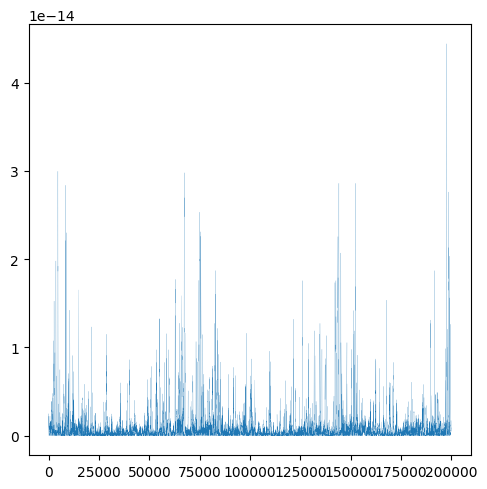

In [8]:
fits = []
for axis in range(2):
    fitsforaxis = []
    axis_alphas = alphas[axis]
    for i, power_tuple in enumerate(data[:-1]):
        alpha = axis_alphas[i]
        trial_fits = []
        for trial_data in power_tuple:
            print(trial_data[:,axis])
            dat = trial_data[:,axis] * qpd_x_to_pos[i] * 1e-6
            print(dat, len(dat), max(dat))
            avgx = np.sum(dat) / len(dat)
            print((dat - avgx) ** 2, max((dat - avgx) ** 2))
            vari = np.sum((dat - avgx) ** 2) / len(dat)
            print(vari)
            print(alpha * 1/(T / vari))
            plt.plot((dat - avgx) ** 2, lw=0.1)
            plt.show()
            



In [9]:
gc = np.array([[0, 0.09, 0.81, 0], [0.81, 0.09, 0, 0], [0, 0, 0.09, 0.81], [0.81, 0, 0, 0.09]])
lhs = np.identity(4) - gc
rhs = np.array([[0], [1], [0], [2]])

v = np.linalg.solve(lhs, rhs)
print(v.reshape(4))

[6.05288295 6.48663207 6.7519581  7.58553317]
